# Lecture 3: Linear and Logistic Regression

http://web.stanford.edu/class/cs20si/lectures/slides_03.pdf

Simple linear regression example in TensorFlow
This program tries to predict the number of thefts from 
the number of fire in the city of Chicago

In [18]:
"""
All imports
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd
from util import newlogname
import sys
from tensorflow.examples.tutorials.mnist import input_data
import time

%matplotlib inline


# Linear Regression

In [2]:
DATA_FILE = 'data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

In [3]:
print("Dataset size = ", len(data))
print("\nFirst 5 observations of the dataset:\n")
print(data[0:5])

Dataset size =  42

First 5 observations of the dataset:

[[  6.2  29. ]
 [  9.5  44. ]
 [ 10.5  36. ]
 [  7.7  37. ]
 [  8.6  53. ]]


### Defining the model, i.e., the graph and the session for training

In [11]:
def linear_regression(log_path, lr=0.001,loss_function=None):
    
    graph = tf.Graph() 
    with graph.as_default():
        # Step 2: create placeholders for input X (number of fire) and label Y (number of theft)

        number_fire = tf.placeholder(tf.float32,shape=[],name="X")
        number_theft = tf.placeholder(tf.float32,shape=[],name="Y")


        # Step 3: create weight and bias, initialized to 0
        # name your variables w and b
        with tf.name_scope("Weights"):
            weight = tf.get_variable("w",dtype=tf.float32,initializer=0.)
            bias = tf.get_variable("b",dtype=tf.float32,initializer=0.)
            tf.summary.histogram('weights_summ',weight)
            tf.summary.histogram('bias_summ',bias)

        # Step 4: predict Y (number of theft) from the number of fire
        # name your variable Y_predicted
        with tf.name_scope("linear-model"):
            Y_predicted = (number_fire*weight) + bias 

        # Step 5: use the square error as the loss function
        # name your variable loss
        with tf.name_scope("loss-fuction"):
            if loss_function is None:
                loss = tf.pow((Y_predicted -number_theft),2)
            else:
                loss = loss_function(number_theft, Y_predicted)
            tf.summary.scalar("loss",loss)

        # Step 6: using gradient descent with learning rate of 0.01 to minimize loss
        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)


    # Phase 2: Train our model
    with tf.Session(graph=graph) as sess:
        print("\n ==Beggining training for lr={}==".format(lr))
        summary_writer = tf.summary.FileWriter(log_path,sess.graph)
        all_summaries = tf.summary.merge_all() 
        # Step 7: initialize the necessary variables, in this case, w and b
        tf.global_variables_initializer().run()
        # Step 8: train the model
        step = 0
        total_steps = len(data)*100
        for i in range(100): # run 100 epochs
            total_loss = 0
            for x, y in data:
                # Session runs optimizer to minimize loss and fetch the value of loss
                step += 1
                feed_dict = {number_fire:x, number_theft:y}
                _,l,summary,w,b = sess.run([optimizer,loss,all_summaries, weight,bias], feed_dict=feed_dict)

                #writing the log
                summary_writer.add_summary(summary,step)
                summary_writer.flush()

                total_loss += l
                # sys.stdout.write('\r{} / {} : pp = {}'.format(step, total_steps,total_loss))
                # sys.stdout.flush()
            if i%10==0:
                print("\nEpoch {0}: {1}".format(i, total_loss/n_samples))
    return total_loss,w,b



### After defined the model we can run different trainings with different learning rates to check which one is the best

In [12]:
all_lr = [0.0009,0.00087,0.00075,0.0012,0.002]
best_loss = float('inf')
best_lr = 0
w = 0
b = 0 
for lr in all_lr:
    path_log = './graphs/' + str(lr)
    current_loss,current_w, current_b = linear_regression(path_log,lr)
    if current_loss < best_loss:
        best_loss, best_lr = current_loss, lr
        w, b = current_w, current_b
print("\nthe best lr is {0}, with loss = {1}".format(best_lr,best_loss/n_samples))


 ==Beggining training for lr=0.0009==

Epoch 0: 1775.2119261437938

Epoch 10: 1653.5637995948393

Epoch 20: 1537.7932460307466

Epoch 30: 1454.4950013958983

Epoch 40: 1393.7797238769099

Epoch 50: 1349.005913916798

Epoch 60: 1315.6468483918745

Epoch 70: 1290.5730496667647

Epoch 80: 1271.584222030216

Epoch 90: 1257.114225530997

 ==Beggining training for lr=0.00087==

Epoch 0: 1696.1530765706584

Epoch 10: 1578.6739477940969

Epoch 20: 1472.5063404076334

Epoch 30: 1395.6836117442165

Epoch 40: 1339.392999981131

Epoch 50: 1297.6737101645697

Epoch 60: 1266.4380452441746

Epoch 70: 1242.84422111412

Epoch 80: 1224.8863509127737

Epoch 90: 1211.13078761562

 ==Beggining training for lr=0.00075==

Epoch 0: 1421.2475874310448

Epoch 10: 1310.3567895946048

Epoch 20: 1237.2140785129297

Epoch 30: 1183.1046448818274

Epoch 40: 1142.6468263798909

Epoch 50: 1112.0881879467163

Epoch 60: 1088.786351671531

Epoch 70: 1070.8637784969594

Epoch 80: 1056.970183225526

Epoch 90: 1046.12495179

## ploting the results

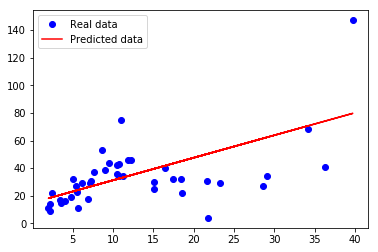

In [13]:
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

### Now we can use tensorboad to see witch one is the best hyper param. For doing so, we need to set loogdir to the parent folder

In [7]:
#!tensorboard --logdir=./graphs --port=8008

## Huber loss

Robust to outliers

Intuition: if the difference between the predicted value and the real value is small, square it If it’s large, take its absolute value

   
- $L_{\delta}(y,f(x)) =  \frac{1}{2}(y-f(x))^{2}$ if $|y-f(x)|\leq \delta$

- $L_{\delta}(y,f(x)) =  \delta|y-f(x)| -\frac{1}{2}\delta^{2}$ otherwise 


In [15]:
#implementing Huber loss in tf
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * tf.square(residual)
    large_res = delta * residual - 0.5 * tf.square(delta)
    return tf.where(condition, small_res, large_res)

**Now repeating the training with Huber loss**

In [16]:
all_lr = [0.0009,0.00087,0.00075,0.0012,0.002]
best_loss = float('inf')
best_lr = 0
w = 0
b = 0 
for lr in all_lr:
    path_log = './graphs/' + str(lr)
    current_loss,current_w, current_b = linear_regression(path_log,lr,huber_loss)
    if current_loss < best_loss:
        best_loss, best_lr = current_loss, lr
        w, b = current_w, current_b
print("\nthe best lr is {0}, with loss = {1}".format(best_lr,best_loss/n_samples))


 ==Beggining training for lr=0.0009==

Epoch 0: 30.5058015641712

Epoch 10: 16.53957552613602

Epoch 20: 16.472495969917095

Epoch 30: 16.40623512354103

Epoch 40: 16.341193102898874

Epoch 50: 16.27731665216076

Epoch 60: 16.213774049571448

Epoch 70: 16.15062386205786

Epoch 80: 16.08786667798094

Epoch 90: 16.025500217763085

 ==Beggining training for lr=0.00087==

Epoch 0: 30.588147572108678

Epoch 10: 16.53861704273593

Epoch 20: 16.473600614283765

Epoch 30: 16.409472711428645

Epoch 40: 16.34647723934835

Epoch 50: 16.284601737523364

Epoch 60: 16.223123986124328

Epoch 70: 16.161989735882905

Epoch 80: 16.10121916447367

Epoch 90: 16.04081069217119

 ==Beggining training for lr=0.00075==

Epoch 0: 30.917532228288195

Epoch 10: 16.610250842896114

Epoch 20: 16.47840994507784

Epoch 30: 16.4228663751412

Epoch 40: 16.368149911408267

Epoch 50: 16.31424934665362

Epoch 60: 16.261060962231742

Epoch 70: 16.208056159289775

Epoch 80: 16.155315083091235

Epoch 90: 16.102832949631626

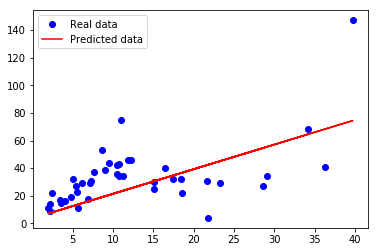

In [17]:
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

# Logistic Regression

In [32]:
# Define paramaters for the model
lr = 0.01
batch_size = 128
n_epochs = 10

num_classes = 10

In [21]:
# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder data/mnist
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [62]:
num_classes = 10

def logistic_regression(lr=0.01,batch_size=128,n_epochs=10,log_path=None):

    graph = tf.Graph()
    with graph.as_default():
        # Step 2: create placeholders for features and labels
        # each image in the MNIST data is of shape 28*28 = 784
        # therefore, each image is represented with a 1x784 tensor
        # there are 10 classes for each image, corresponding to digits 0 - 9.

        X = tf.placeholder(tf.float32,shape=(batch_size ,784), name="X")
        Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")

        # Step 3: create weights and bias
        # weights and biases are initialized to 0
        # shape of w depends on the dimension of X and Y so that Y = X * w + b
        # shape of b depends on Y

        with tf.name_scope("Weights"):
            w_shape = (784,num_classes)
            b_shape = (num_classes)
            w_init = tf.zeros(w_shape)
            b_init = tf.zeros(b_shape)
            weight = tf.get_variable("w",dtype=tf.float32,initializer=w_init)
            bias = tf.get_variable("b",dtype=tf.float32,initializer=b_init)
            tf.summary.histogram('weights_summ',weight)
            tf.summary.histogram('bias_summ',bias)


        # Step 4: build model
        # the model that returns the logits.
        # this logits will be later passed through softmax layer
        # to get the probability distribution of possible label of the image
        # DO NOT DO SOFTMAX HERE

        with tf.name_scope("Linear_layer"):
            logits = tf.add(tf.matmul(X,weight),bias,name="logits")

        # Step 5: define loss function
        # use cross entropy loss of the real labels with the softmax of logits
        # use the method:
        # tf.nn.softmax_cross_entropy_with_logits(logits, Y)
        # then use tf.reduce_mean to get the mean loss of the batch

        with tf.name_scope("loss"):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=Y))
            tf.summary.scalar("loss",loss)


        # Step 6: define training op
        # using gradient descent to minimize loss

        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
            
    if log_path is None:
        log_path = newlogname()
        print("\n&&&&&log_path={}&&&&&".format(log_path))

    with tf.Session(graph=graph) as sess:
        print("\n==Beggining training for lr={0}, batch_size={1} and n_epochs={2}==".format(lr,batch_size,n_epochs))
        summary_writer = tf.summary.FileWriter(log_path,sess.graph)
        all_summaries = tf.summary.merge_all() 
        start_time = time.time()
        sess.run(tf.global_variables_initializer())	
        n_batches = int(mnist.train.num_examples/batch_size)
        for i in range(n_epochs): # train the model n_epochs times
            total_loss = 0
            for _ in range(n_batches):
                X_batch, Y_batch = mnist.train.next_batch(batch_size)
                feed_dict = {X: X_batch, Y: Y_batch}
                _,loss_batch,summary = sess.run([optimizer,loss,all_summaries], feed_dict=feed_dict)
                total_loss += loss_batch
            print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

        print('Total time: {0} seconds'.format(time.time() - start_time))

        print('Optimization Finished!') # should be around 0.35 after 25 epochs

        # test the model
        n_batches = int(mnist.test.num_examples/batch_size)
        total_correct_preds = 0
        for i in range(n_batches):
            X_batch, Y_batch = mnist.test.next_batch(batch_size)
            _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X: X_batch, Y:Y_batch}) 
            preds = tf.nn.softmax(logits_batch)
            correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
            accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) # need numpy.count_nonzero(boolarr) :(
        total_correct_preds += sess.run(accuracy)
        print('Accuracy {0}/{1} ={2}'.format(total_correct_preds,mnist.test.num_examples,total_correct_preds/mnist.test.num_examples))

In [63]:
logistic_regression()


&&&&&log_path=./graphs/03-03-2017_21-47-08&&&&&

==Beggining training for lr=0.01, batch_size=128 and n_epochs=10==
Average loss epoch 0: 1.2884496112803479
Average loss epoch 1: 0.7328035713353634
Average loss epoch 2: 0.6008441435012506
Average loss epoch 3: 0.5368735335228882
Average loss epoch 4: 0.49813148302909654
Average loss epoch 5: 0.4712426028190515
Average loss epoch 6: 0.45082001016412304
Average loss epoch 7: 0.43598701869135414
Average loss epoch 8: 0.4227202563852697
Average loss epoch 9: 0.4121868123402407
Total time: 7.2182886600494385 seconds
Optimization Finished!
Accuracy 112.0/10000 =0.0112
